In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
from torch import optim
from torchvision import transforms
from torchvision import datasets
import torchvision
import os

In [2]:
# [DCGAN.ipynb](https://github.com/chenyuntc/pytorch-GAN/blob/master/DCGAN.ipynb) DCGAN相关代码

In [3]:
# nn.ConvTranspose2d?
# transforms.Normalize?

In [4]:
noise_size = 100
g_size = 64
d_size = 64
batch_size = 32
img_size = 64

In [5]:
netg = nn.Sequential(
    # 1*1 to 4*4
    nn.ConvTranspose2d(in_channels=noise_size, out_channels=g_size*8, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(g_size*8),
    nn.ReLU(True),
    
    # 4*4 to 8*8
    nn.ConvTranspose2d(in_channels=g_size*8, out_channels=g_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(g_size*4),
    nn.ReLU(True),
    
    # 8*8 to 16*16
    nn.ConvTranspose2d(in_channels=g_size*4, out_channels=g_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(g_size*2),
    nn.ReLU(True),
    
    # 16*16 to 32*32
    nn.ConvTranspose2d(in_channels=g_size*2, out_channels=g_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(g_size),
    nn.ReLU(True),
    
    # 32*32 to 64*64
    nn.ConvTranspose2d(in_channels=g_size, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
)

In [6]:
netd = nn.Sequential(
    # 64*64 to 32*32
    nn.Conv2d(in_channels=3, out_channels=d_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    
    # 32*32 to 16*16
    nn.Conv2d(in_channels=d_size, out_channels=d_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(d_size*2),
    nn.LeakyReLU(0.2, inplace=True),
    
    # 16*16 to 8*8
    nn.Conv2d(in_channels=d_size*2, out_channels=d_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(d_size*4),
    nn.LeakyReLU(0.2, inplace=True),
    
    # 8*8 to 4*4
    nn.Conv2d(in_channels=d_size*4, out_channels=d_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(d_size*8),
    nn.LeakyReLU(0.2, inplace=True),
    
    # 4*4 to 1*1
    nn.Conv2d(in_channels=d_size*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid()
)

In [7]:
optimizer_g = optim.Adam(netg.parameters(), lr=0.0002)

In [8]:
optimizer_d = optim.Adam(netd.parameters(), lr=0.0002)

In [9]:
criterion = nn.BCELoss() # binary cross entropy

In [10]:
fixed_noise = Variable(torch.FloatTensor(batch_size, noise_size, 1, 1).normal_(0, 1))

In [11]:
fixed_noise.data.size()

torch.Size([32, 100, 1, 1])

In [12]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [13]:
dataset = datasets.CIFAR10(root=os.path.expanduser('~/Data/pytorch/'), transform=transform, download=True)

Files already downloaded and verified


In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

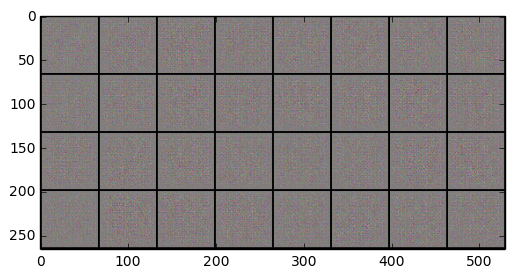

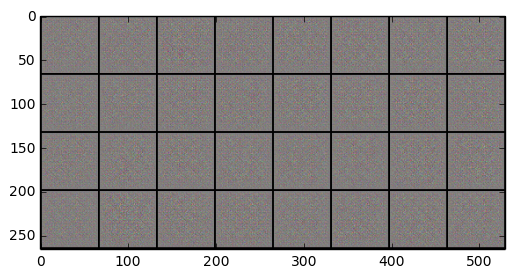

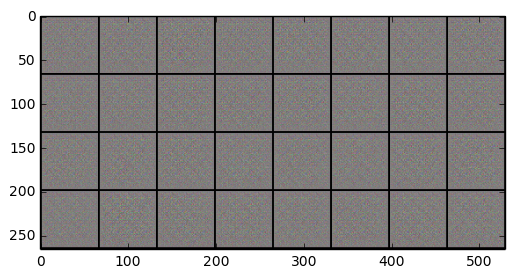

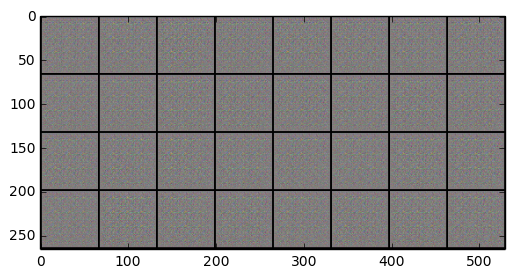

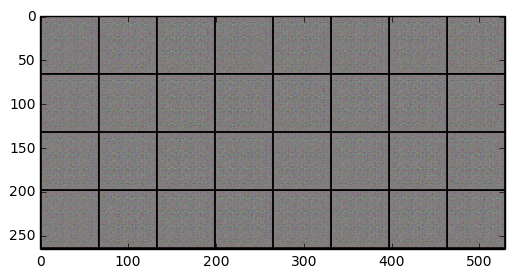

In [15]:
for epoch in range(10):
    # 加载图像和label（这里不需要）
    for real_image_batch, _ in dataloader:
#         print(real_image_batch.size())
        real_image_batch_var = Variable(real_image_batch)
        real_label_var = Variable(torch.ones(batch_size)) # 1 for real image 0 for fake image
        noise_batch_var = Variable(torch.randn((batch_size, noise_size, 1, 1)))
#         print('noise_batch_var.shape:', noise_batch_var.data.size())
        
        # 训练netd
        optimizer_d.zero_grad()
        
        # 最后的输出是多维
        real_image_pred_var = netd(real_image_batch_var).squeeze()
#         print('real_image_pred_var.shape:', real_image_pred_var.data.size())
        real_error_d = criterion(real_image_pred_var, real_label_var)
        real_error_d.backward()
        
        fake_image_batch_var = netg(noise_batch_var).detach()
#         print('fake_image_batch_var.shape:', fake_image_batch_var.data.size())
        fake_image_pred_var = netd(fake_image_batch_var).squeeze()
        fake_label_var = Variable(torch.zeros(batch_size))
        fake_error_d = criterion(fake_image_pred_var, fake_label_var)
        fake_error_d.backward()
        
        optimizer_d.step()
        
        # 训练netg
        optimizer_g.zero_grad()
        fake_image_batch_var = netg(noise_batch_var)
        fake_label_var = Variable(torch.ones(batch_size)) #使得netd误认为fake为1，即real image
        fake_image_pred_var = netd(fake_image_batch_var).squeeze()
        fake_error_g = criterion(fake_image_pred_var, fake_label_var)
        fake_error_g.backward()
        
        optimizer_g.step()
        break
        
    if epoch%2==0:
        fixed_noise_pred_var = netg(fixed_noise)
        imgs_var_np = torchvision.utils.make_grid(fixed_noise_pred_var.data*0.5+0.5).permute(1,2,0).numpy()
        plt.imshow(imgs_var_np)
        plt.show()